In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess


## Code from Krish (August 1, 2024 in Slack)

In [2]:
data_size = 10**4
sim_size = 10**5
n_iterations = 5
n_bootstraps = 500
epsilon = 1e-8
rcond = 1e-3

rng_seed = 5048
rng = np.random.default_rng(seed = rng_seed )

mu_true, var_true = 0.2, 0.81
mu_gen, var_gen = 0.0, 1.0


smearing = 0.00001
#smearing = 0.25
#smearing = 0.50
#smearing = 0.75

min_bin_width = 0.20

fluctuate_data_size = True


output_dir = 'input-samples-smearing-%.2f-v1b' % smearing


In [3]:
#-- generate one sample to determine binning.

truth = rng.normal(mu_true, np.sqrt(var_true), (data_size))
data = rng.normal(truth, smearing)
gen = rng.normal(mu_gen, np.sqrt(var_gen), (sim_size))
sim = rng.normal(gen, smearing)

In [4]:
bins = [truth.min()]
i = 0
while bins[-1] < truth.max() and i < len(bins):
    for binhigh in np.linspace(bins[i] + epsilon, truth.max(), 200):
        in_bin = (truth > bins[i]) & (truth < binhigh)
        in_reco_bin = (data > bins[i]) & (data < binhigh)
        if np.sum(in_bin) > 0:
            purity = np.sum(in_bin & in_reco_bin) / np.sum(in_bin)
            if purity > (0.5):
                binwid = binhigh - bins[-1]
                if binwid < min_bin_width :
                    binhigh = bins[-1] + min_bin_width
                #print(f"{binhigh = }, {purity = }")
                print(' %3d :  binhigh = %7.3f, purity = %7.3f' % (i, binhigh, purity))
                i += 1
                bins.append(binhigh)
                break
    else:
        break
        
#-- add a last bin
bins.append(truth.max())
        
bins = np.array(bins[1:-1])
bin_widths = np.diff(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
n_bins = len(bins) - 1

   0 :  binhigh =  -2.941, purity =   1.000
   1 :  binhigh =  -2.741, purity =   1.000
   2 :  binhigh =  -2.541, purity =   1.000
   3 :  binhigh =  -2.341, purity =   1.000
   4 :  binhigh =  -2.141, purity =   1.000
   5 :  binhigh =  -1.941, purity =   1.000
   6 :  binhigh =  -1.741, purity =   1.000
   7 :  binhigh =  -1.541, purity =   1.000
   8 :  binhigh =  -1.341, purity =   1.000
   9 :  binhigh =  -1.141, purity =   1.000
  10 :  binhigh =  -0.941, purity =   1.000
  11 :  binhigh =  -0.741, purity =   1.000
  12 :  binhigh =  -0.541, purity =   1.000
  13 :  binhigh =  -0.341, purity =   1.000
  14 :  binhigh =  -0.141, purity =   1.000
  15 :  binhigh =   0.059, purity =   1.000
  16 :  binhigh =   0.259, purity =   1.000
  17 :  binhigh =   0.459, purity =   1.000
  18 :  binhigh =   0.659, purity =   1.000
  19 :  binhigh =   0.859, purity =   1.000
  20 :  binhigh =   1.059, purity =   1.000
  21 :  binhigh =   1.259, purity =   1.000
  22 :  binhigh =   1.459, purit

## End code from Krish.  My stuff below here.

In [5]:
bins

array([-2.94125742, -2.74125742, -2.54125742, -2.34125742, -2.14125742,
       -1.94125742, -1.74125742, -1.54125742, -1.34125742, -1.14125742,
       -0.94125742, -0.74125742, -0.54125742, -0.34125742, -0.14125742,
        0.05874258,  0.25874258,  0.45874258,  0.65874258,  0.85874258,
        1.05874258,  1.25874258,  1.45874258,  1.65874258,  1.85874258,
        2.05874258,  2.25874258,  2.45874258,  2.65874258,  2.85874258,
        3.05874258,  3.25874258,  3.45874258])

In [6]:
print('\n\n')
for bi in range(len(bins)-1) :
    bw = bins[bi+1]-bins[bi]
    print(' %3d :  %7.3f to %7.3f,  bin width = %7.3f' % (bi, bins[bi], bins[bi+1], bw))
print('\n\n')




   0 :   -2.941 to  -2.741,  bin width =   0.200
   1 :   -2.741 to  -2.541,  bin width =   0.200
   2 :   -2.541 to  -2.341,  bin width =   0.200
   3 :   -2.341 to  -2.141,  bin width =   0.200
   4 :   -2.141 to  -1.941,  bin width =   0.200
   5 :   -1.941 to  -1.741,  bin width =   0.200
   6 :   -1.741 to  -1.541,  bin width =   0.200
   7 :   -1.541 to  -1.341,  bin width =   0.200
   8 :   -1.341 to  -1.141,  bin width =   0.200
   9 :   -1.141 to  -0.941,  bin width =   0.200
  10 :   -0.941 to  -0.741,  bin width =   0.200
  11 :   -0.741 to  -0.541,  bin width =   0.200
  12 :   -0.541 to  -0.341,  bin width =   0.200
  13 :   -0.341 to  -0.141,  bin width =   0.200
  14 :   -0.141 to   0.059,  bin width =   0.200
  15 :    0.059 to   0.259,  bin width =   0.200
  16 :    0.259 to   0.459,  bin width =   0.200
  17 :    0.459 to   0.659,  bin width =   0.200
  18 :    0.659 to   0.859,  bin width =   0.200
  19 :    0.859 to   1.059,  bin width =   0.200
  20 :    1.059 t

In [7]:
sim_scale_factor = (1.*data_size)/(1.*sim_size)
sim_simple_weights = sim_scale_factor*np.ones(shape=(sim_size))

<function matplotlib.pyplot.show(close=None, block=None)>

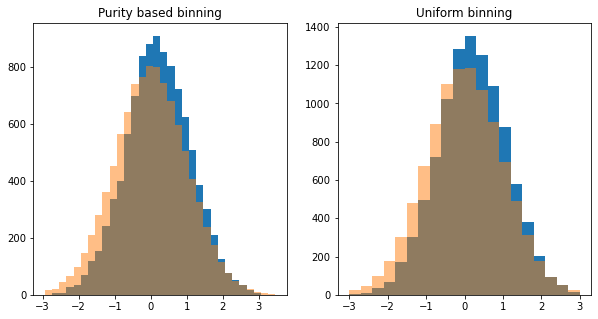

In [8]:

phbins=20
pxmin=-3.
pxmax=3.


fig,ax = plt.subplots( 1, 2, figsize=(2*5,5))

axi = ax[0]
axi.hist( data, bins=bins)
axi.hist( sim, bins=bins, weights=sim_simple_weights, alpha=0.5)

axi = ax[1]
plt.hist( data, bins=phbins, range=[pxmin,pxmax] )
plt.hist( sim, bins=phbins, range=[pxmin,pxmax], weights=sim_simple_weights, alpha=0.5 )

ax[0].set_title('Purity based binning')
ax[1].set_title('Uniform binning')


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

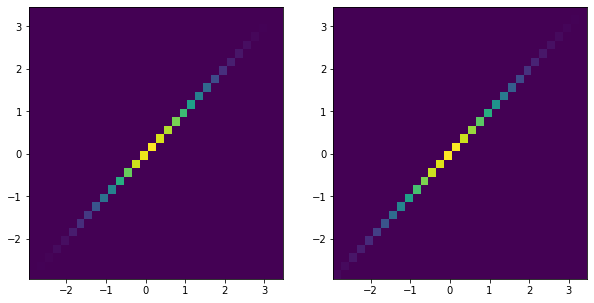

In [9]:


fig,ax = plt.subplots( 1, 2, figsize=(2*5,5))

axi = ax[0]
h2d_data,_,_,_ = axi.hist2d( truth, data, bins=[bins,bins])

axi = ax[1]
h2d_sim,_,_,_ = axi.hist2d( gen, sim, bins=[bins,bins])

plt.show


   0 :  max data    1.000,   max sim    1.000
   1 :  max data    1.000,   max sim    1.000
   2 :  max data    1.000,   max sim    1.000
   3 :  max data    1.000,   max sim    1.000
   4 :  max data    1.000,   max sim    1.000
   5 :  max data    1.000,   max sim    1.000
   6 :  max data    1.000,   max sim    1.000
   7 :  max data    1.000,   max sim    1.000
   8 :  max data    1.000,   max sim    1.000
   9 :  max data    1.000,   max sim    1.000
  10 :  max data    1.000,   max sim    1.000
  11 :  max data    1.000,   max sim    1.000
  12 :  max data    1.000,   max sim    1.000
  13 :  max data    1.000,   max sim    1.000
  14 :  max data    1.000,   max sim    1.000
  15 :  max data    1.000,   max sim    1.000
  16 :  max data    1.000,   max sim    1.000
  17 :  max data    1.000,   max sim    1.000
  18 :  max data    1.000,   max sim    1.000
  19 :  max data    1.000,   max sim    1.000
  20 :  max data    1.000,   max sim    1.000
  21 :  max data    1.000,   max s

<function matplotlib.pyplot.show(close=None, block=None)>

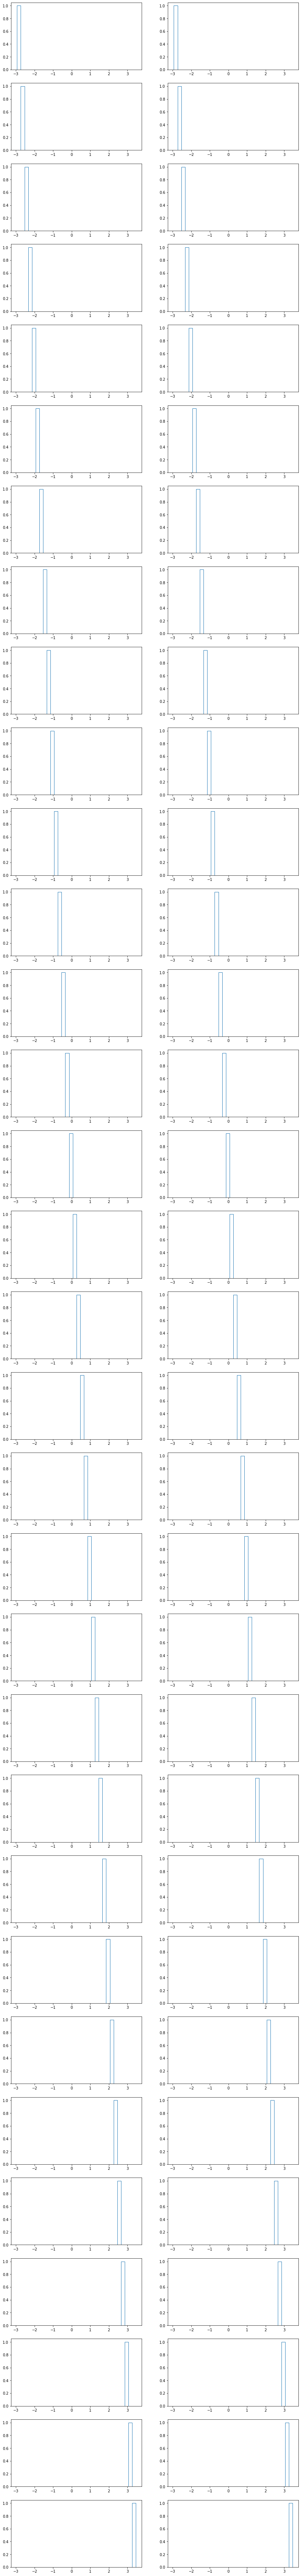

In [10]:
fig,ax = plt.subplots( n_bins, 2, figsize=(2*7,n_bins*4))

for bi in range(n_bins) :
    
    axi=ax[bi,0]
    hsum = np.sum(h2d_data[bi,:])
    axi.stairs( (1./hsum)*h2d_data[bi,:], edges=bins )
    max_data = np.max( (1./hsum)*h2d_data[bi,:] )
    
    axi=ax[bi,1]
    hsum = np.sum(h2d_sim[bi,:])
    axi.stairs( (1./hsum)*h2d_sim[bi,:], edges=bins )
    max_sim = np.max( (1./hsum)*h2d_sim[bi,:] )
    
    print(' %3d :  max data  %7.3f,   max sim  %7.3f' % (bi, max_data, max_sim ))
    
plt.show

## Write the samples to files in an output directory

In [11]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [12]:
out_file = '%s/config.txt' % output_dir

text_file = open( out_file, 'w' )

text_file.write( 'data_size %d\n' % data_size )
text_file.write( 'sim_size  %d\n' % sim_size )
text_file.write( 'n_bootstraps %d\n' % n_bootstraps )
text_file.write( 'rng_seed %d\n' % rng_seed  )
text_file.write( 'mu_true  %.4f\n' % mu_true )
text_file.write( 'mu_gen   %.4f\n' % mu_gen )
text_file.write( 'var_true   %.4f\n' % var_true )
text_file.write( 'var_gen    %.4f\n' % var_gen )
text_file.write( 'smearing  %.2f\n' % smearing )
text_file.write( 'min_bin_width  %.4f\n' % min_bin_width )


text_file.close()

print('\n\n')

print( subprocess.getoutput('cat %s' % out_file ))

print('\n\n')







data_size 10000
sim_size  100000
n_bootstraps 500
rng_seed 5048
mu_true  0.2000
mu_gen   0.0000
var_true   0.8100
var_gen    1.0000
smearing  0.00
min_bin_width  0.2000





In [13]:

out_file = '%s/binning.npy' % output_dir
print('\n\n Saving binning in %s\n\n' % out_file )

with open( out_file, 'wb' ) as f :
    np.save( f, bins )
    np.save( f, bin_widths )
    np.save( f, bin_centers )
    np.save( f, n_bins )
    
out_file = '%s/binning.txt' % output_dir
print(' Saving in human readable format: %s\n\n' % out_file )

text_file = open( out_file, 'w' )

text_file.write( 'bins ' )
text_file.write( '%s\n' % str(bins) )

text_file.write( 'bin_widths ' )
text_file.write( '%s\n' % str(bin_widths) )

text_file.write( 'bin_centers ' )
text_file.write( '%s\n' % str(bin_centers) )

text_file.write( 'n_bins ' )
text_file.write( '%s\n' % str(n_bins) )

text_file.close()


print( subprocess.getoutput('cat %s' % out_file ))

print('\n\n')




 Saving binning in input-samples-smearing-0.00-v1b/binning.npy


 Saving in human readable format: input-samples-smearing-0.00-v1b/binning.txt


bins [-2.94125742 -2.74125742 -2.54125742 -2.34125742 -2.14125742 -1.94125742
 -1.74125742 -1.54125742 -1.34125742 -1.14125742 -0.94125742 -0.74125742
 -0.54125742 -0.34125742 -0.14125742  0.05874258  0.25874258  0.45874258
  0.65874258  0.85874258  1.05874258  1.25874258  1.45874258  1.65874258
  1.85874258  2.05874258  2.25874258  2.45874258  2.65874258  2.85874258
  3.05874258  3.25874258  3.45874258]
bin_widths [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
bin_centers [-2.84125742 -2.64125742 -2.44125742 -2.24125742 -2.04125742 -1.84125742
 -1.64125742 -1.44125742 -1.24125742 -1.04125742 -0.84125742 -0.64125742
 -0.44125742 -0.24125742 -0.04125742  0.15874258  0.35874258  0.55874258
  0.75874258  0.95874258  1.15874258  1.35874258  1.55874258  1.75874258

In [14]:
for si in range( n_bootstraps ) :
    
    out_file = '%s/sample-%04d.npy' % ( output_dir, si )
    


    this_data_size = data_size
    if fluctuate_data_size : this_data_size = rng.poisson( data_size )
    
    print(' %4d : Saving sample in file %s,  this_data_size %8d' % (si, out_file, this_data_size))
    
    truth = rng.normal(mu_true, np.sqrt(var_true), (this_data_size))
    data = rng.normal(truth, smearing)
    gen = rng.normal(mu_gen, np.sqrt(var_gen), (sim_size))
    sim = rng.normal(gen, smearing)    
    
    
    with open( out_file, 'wb' ) as f :
        np.save( f, truth )
        np.save( f, data )
        np.save( f, gen )
        np.save( f, sim )
    
    

    0 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0000.npy,  this_data_size     9924
    1 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0001.npy,  this_data_size    10025
    2 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0002.npy,  this_data_size     9821
    3 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0003.npy,  this_data_size     9966
    4 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0004.npy,  this_data_size     9899
    5 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0005.npy,  this_data_size     9999
    6 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0006.npy,  this_data_size     9840
    7 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0007.npy,  this_data_size    10105
    8 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0008.npy,  this_data_size     9863
    9 : Saving sample in file input-samples-smearing-0.00-v1b/sa

   88 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0088.npy,  this_data_size     9788
   89 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0089.npy,  this_data_size     9992
   90 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0090.npy,  this_data_size     9928
   91 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0091.npy,  this_data_size     9981
   92 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0092.npy,  this_data_size     9963
   93 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0093.npy,  this_data_size     9922
   94 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0094.npy,  this_data_size     9903
   95 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0095.npy,  this_data_size     9924
   96 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0096.npy,  this_data_size     9956
   97 : Saving sample in file input-samples-smearing-0.00-v1b/sa

  180 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0180.npy,  this_data_size     9971
  181 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0181.npy,  this_data_size    10041
  182 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0182.npy,  this_data_size     9834
  183 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0183.npy,  this_data_size    10149
  184 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0184.npy,  this_data_size     9785
  185 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0185.npy,  this_data_size    10074
  186 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0186.npy,  this_data_size     9974
  187 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0187.npy,  this_data_size    10049
  188 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0188.npy,  this_data_size    10156
  189 : Saving sample in file input-samples-smearing-0.00-v1b/sa

  272 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0272.npy,  this_data_size     9980
  273 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0273.npy,  this_data_size     9908
  274 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0274.npy,  this_data_size     9947
  275 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0275.npy,  this_data_size     9958
  276 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0276.npy,  this_data_size     9929
  277 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0277.npy,  this_data_size     9935
  278 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0278.npy,  this_data_size    10008
  279 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0279.npy,  this_data_size     9942
  280 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0280.npy,  this_data_size    10053
  281 : Saving sample in file input-samples-smearing-0.00-v1b/sa

  364 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0364.npy,  this_data_size     9952
  365 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0365.npy,  this_data_size     9989
  366 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0366.npy,  this_data_size    10022
  367 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0367.npy,  this_data_size     9959
  368 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0368.npy,  this_data_size     9979
  369 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0369.npy,  this_data_size     9939
  370 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0370.npy,  this_data_size     9747
  371 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0371.npy,  this_data_size    10022
  372 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0372.npy,  this_data_size    10039
  373 : Saving sample in file input-samples-smearing-0.00-v1b/sa

  456 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0456.npy,  this_data_size    10242
  457 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0457.npy,  this_data_size     9916
  458 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0458.npy,  this_data_size    10038
  459 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0459.npy,  this_data_size     9927
  460 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0460.npy,  this_data_size    10179
  461 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0461.npy,  this_data_size     9908
  462 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0462.npy,  this_data_size    10027
  463 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0463.npy,  this_data_size    10091
  464 : Saving sample in file input-samples-smearing-0.00-v1b/sample-0464.npy,  this_data_size     9886
  465 : Saving sample in file input-samples-smearing-0.00-v1b/sa